In [33]:
# Python kütüphanelerini içe aktarma
import pickle                                    # Verileri Serileştirme - Verilerin Yüklenmesi (Data Load)
import numpy as np                               # Numerik Analiz
import matplotlib.pyplot as plt                  # Verilerin Görselleştirilmesi 
import random                                    # Rastgele Sayı Üretimi
import cv2                                       # Eğitim görüntülerini gri tonlamaya dönüştürmek için
import skimage.morphology as morp                # morfoloji fonksiyonumuzu oluştururken kullanacağız.
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os                                        #Çalıştığınız klasör içerisindeki klasör ve dosyaların liste
import tensorflow as tf                          # Makine ve Derin Öğrenme Modellerinin Oluşturulması
from tensorflow import keras
from tensorflow.contrib.layers import flatten    
from sklearn.metrics import confusion_matrix     #Confusion matriks oluşturmaya yarıyan sklearn kütüphanesi

# Geçerli TensorFlow sürümünü gösterelim
tf.__version__

'1.12.0'

# 1. Adım: Verileri Yükleyin
Veri setini buradan indirin. Bu, görüntüleri zaten 32x32 olarak yeniden boyutlandırdığımız, seçilmiş bir veri kümesidir.

Halihazırda 32x32 yeniden boyutlandırılmış görüntülerden oluşan üç .p dosyamız var:

train.p: Eğitim seti.
test.p: Test seti.
valid.p: Doğrulama seti.
Verileri yüklemek için Python pickle kullanacağız.

In [34]:
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num of GPUs available:  13


In [35]:
#Pickle kullanılarak .p formatındaki model train&valid&test olarak değişkenlere atanır.
training_file = "./trafficSignsDataset/train.p"
validation_file= "./trafficSignsDataset/valid.p"
testing_file = "./trafficSignsDataset/test.p"

with open(training_file, mode='rb') as training_data:
    train = pickle.load(training_data)
with open(validation_file, mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open(testing_file, mode='rb') as testing_data:
    test = pickle.load(testing_data)


In [36]:
# ClassID'lerin trafik işareti adlarıyla eşlemek için classlarımız.
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

# 2. Adım: Veri Kümesi Özeti ve Keşif
Seçilen veriler, 4 anahtar/değer çifti içeren bir sözlüktür:

    'features': trafik işareti görüntülerinin ham piksel verilerini içeren bir 4D dizisidir (sayı örnekleri, genişlik, yükseklik, kanallar).
    'labels': trafik işaretinin etiket/sınıf kimliğini içeren bir 1 boyutlu dizidir. Signnames.csv dosyası, her kimlik için kimlik -> ad eşlemelerini içerir.
    'sizes': görüntünün orijinal genişliğini ve yüksekliğini temsil eden demetleri (genişlik, yükseklik) içeren bir listedir.
    'coords': görüntüdeki işaretin etrafındaki sınırlayıcı kutunun koordinatlarını temsil eden demetleri (x1, y1, x2, y2) içeren bir listedir.
Aşağıdaki kod parçacıkları, Veri Kümesinin temel bir özetini sağlayacaktır.

İlk olarak, görüntü boyutuna ek olarak alt kümedeki görüntü sayısını ve benzersiz sınıfların sayısını kullanmak ve değişkenlere atamak için numpy kütüphanesini kullanacağız.

In [37]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Eğitim örneklerinin sayısı
n_train = X_train.shape[0]

# Test örneklerinin sayısı
n_test = X_test.shape[0]

# Doğrulama örneklerinin sayısı.
n_validation = X_valid.shape[0]

# Bir trafik işareti  şekli nedir?
image_shape = X_train[0].shape

# Veri kümesinde kaç tane benzersiz sınıf/etiket vardır.
n_classes = len(np.unique(y_train))

print("Eğitim örneklerinin sayısı: ", n_train)
print("Test örneklerinin sayısı: ", n_test)
print("Doğrulama örneklerinin sayısı: ", n_validation)
print("Bir trafik işareti  şekli nedir =", image_shape)
print("Veri kümesinde kaç tane benzersiz sınıf/etiket vardır =", n_classes)

Eğitim örneklerinin sayısı:  34799
Test örneklerinin sayısı:  12630
Doğrulama örneklerinin sayısı:  4410
Bir trafik işareti  şekli nedir = (32, 32, 3)
Veri kümesinde kaç tane benzersiz sınıf/etiket vardır = 43


In [38]:
#Görsellerimizi Önizlememizi sağlayacak fonksiyonun oluşturulması.
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Matplotlib ile görüntülerin bir listesini tek bir şekilde görüntülememize yarayan fonksiyon.
        parametreler:
            görüntüler: plt.imshow ile uyumlu bir np.array.
            label (Varsayılan = Etiket yok): Her görüntü için etiket olarak kullanılacak bir dize.
            cmap (Varsayılan = Yok): Gri görüntüleri görüntülemek için kullanılır.
    """
    plt.figure(figsize=(15, 16))#görsellerin kaçar piksellik göstereceeğimizi seçiyoruz.
    for i in range(6):          #6'şar adet görsel listelemek için
        plt.subplot(1, 6, i+1)  #bir sonraki görseli yerleştirmek için subplot kullandık
        indx = random.randint(0, len(dataset))
        #Yalnızca bir kanal varsa gri tonlamalı renkli harita kullanın
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]]) #görsellerin eşleştiği classı yazdırma.
        plt.ylabel(ylabel) #görselin hangi sınıfa ait olduğunun yazılması y eksenine
        plt.xticks([]) #görsellerin çerçevesinde uzunluk koordinat sayılarının görüntülenmesini engelledik.
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0) #görseller arasında boşlukların boyutunun düzenlenmesi.
    plt.show() #görsellerin gösterilmesi.

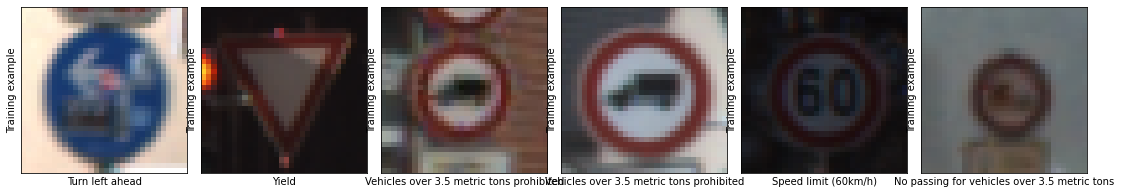

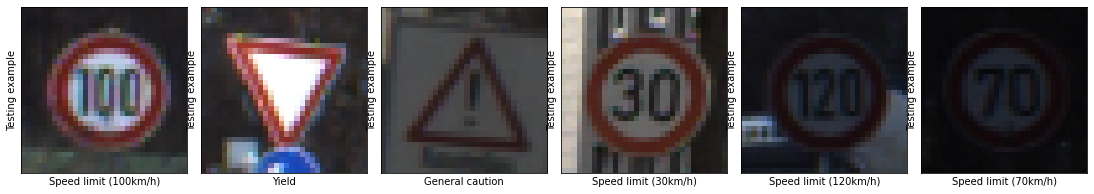

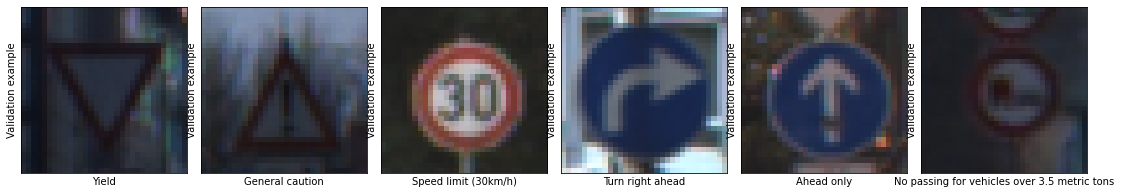

In [39]:
# Görsellerin örnekleri
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

In [40]:
def histogram_plot(dataset, label):
    """
    Giriş verilerinin bir histogramını çizer.
        parametreler:
            veri kümesi: Histogram olarak çizilecek girdi verileri.
            label: Histogram için etiket olarak kullanılacak bir dize.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)#bins kaç adet kutu kolon olusturacagımız.
    width = 0.7 * (bins[1] - bins[0]) #kolonların boyutunu ayarlama güzel görüntü için.
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)#bar chart çizeceğimiz için bar yazdıktan sopnra özellikleride belirttik tanımlamış olduğumuz.
    plt.xlabel(label)#hangi chart olduğunu anlamamızı sağlayan değişkenin ismi.
    plt.ylabel("Image count")#43 farklı clasımızdan kaçar adet olduğunu gösterecek y ekseninde duran etiket adı
    plt.show()

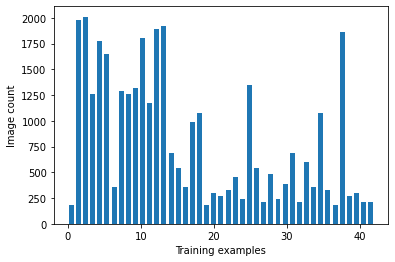

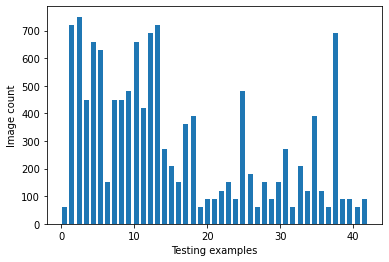

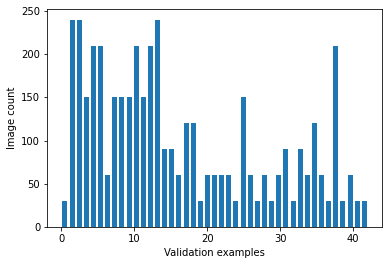

In [41]:
# Her işaret sayısının histogramlarını çizme
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

# 3. Adım: Veri Ön İşleme
Bu adımda, mümkün olan en iyi sonuçları elde etmek için giriş görüntülerine birkaç ön işleme adımı uygulayacağız.

Aşağıdaki ön işleme tekniklerini kullanacağız:

1.karıştırma.

2.Gri tonlama.

3.Yerel Histogram Eşitleme.

4.normalleştirme.


    1.Karıştırma: Genel olarak, modelin daha kararlı olması için eğitim veri setindeki rastgeleliği ve çeşitliliği artırmak için eğitim verilerini karıştırırız. Verilerimizi karıştırmak için sklearn kullanacağız.

In [42]:
X_train, y_train = shuffle(X_train, y_train)

    2.Gri tonlama: P. Sermanet ve Y. LeCun, 2011 yılında yayınlanan "Traffic Sign Recognition with Multi-Scale Convolutional Networks" adlı makalelerinde, renk yerine gri tonlamalı görüntülerin kullanılmasının ConvNet'in doğruluğunu artırdığını belirtmişlerdir. Eğitim görüntülerini gri tonlamaya dönüştürmek için OpenCV kullanacağız.

In [43]:
def gray_scale(image):
    """
Görüntüleri gri tonlamaya dönüştürün.
        parametreler:
            görüntü: plt.imshow ile uyumlu bir np.array.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)#İMAGE featuresların içerisindeki renk değerlerini convert etmemize yarıyan kod.

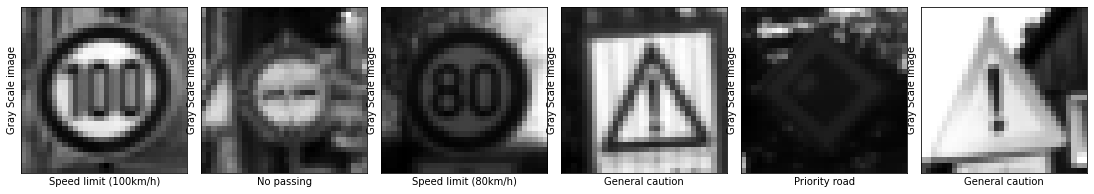

In [44]:
# Gri tonlamadan sonra örnek görüntüler
gray_images = list(map(gray_scale, X_train))#burda fonksiyonu list ve map fonksiyonlarının içerisinde çağırarak çalıştırdık.
list_images(gray_images, y_train, "Gray Scale image", "gray")#yukarda oluşturduğumuz görüntüleri görselleştiren list images fonksiyonumuzu kullandık.

    3.Yerel Histogram Eşitleme: Bu teknik, bir görüntüdeki en sık yoğunluk değerlerini basitçe yayar ve düşük kontrastlı görüntülerin iyileştirilmesiyle sonuçlanır. Eldeki veri seti gerçek dünya görüntülerine sahip olduğundan ve birçoğunun kontrastı düşük olduğundan, bu tekniği uygulamak bizim durumumuzda çok yardımcı olacaktır. Eğitim görüntülerine yerel histogram eşitleme uygulamak için skimage kullanacağız.

In [45]:
def local_histo_equalize(image):
    """
    Gri tonlamalı görüntülere yerel histogram eşitlemesi uygulayın.
        parametreler:
            görüntü: Gri tonlamalı bir görüntü.
    """
    kernel = morp.disk(30)#kontrast ayarlaması yapılması tesworflowun morpology kütüphanesi ile
    img_local = rank.equalize(image, selem=kernel)#veri setine eşitlenmesi
    return img_local

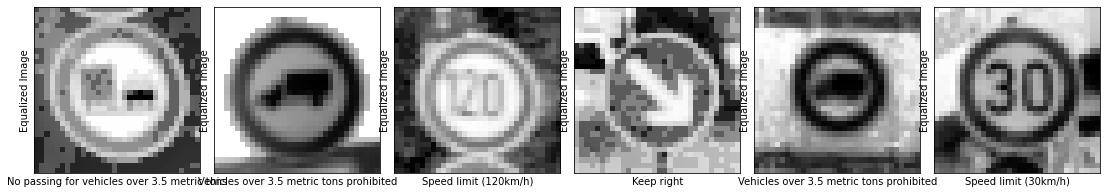

In [46]:
# Yerel Histogram Eşitlemesinden sonra örnek görüntüler
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")


    4.Normalleştirme: Normalleştirme, piksel yoğunluk değerleri aralığını değiştiren bir işlemdir. Genellikle görüntülen verileri, verilerin ortalama sıfır ve eşit varyansa sahip olması için normalize edilmelidir.

In [47]:
def image_normalize(image):
    """
    Görüntüleri [0, 1] ölçeğine göre normalleştirin.
        parametreler:
            görüntü: plt.imshow ile uyumlu bir np.array.
    """
    image = np.divide(image, 255)#verilerin eşiti olmadıgına inandırma.
    return image

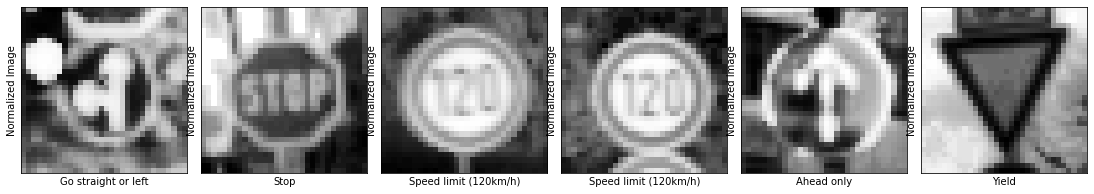

In [48]:
# Normalleştirmeden sonra örnek görüntüler
n_training = X_train.shape  #dizinin her boyutundaki (dimension, örneğin 1D, 2D gibi) elemanların sayısıdır.
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))  #Bu tuple değeri, oluşturmak istediğimiz dizinin boyutlarının değerleridir.
for i, img in enumerate(equalized_images):#indexleme yapıyoruz
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]# boş kalan değer olursa

In [49]:
def preprocess(data):#adım adım oluşturduğumuz fonksiyonları tek bir fonksiyon altında birleştirdik.
    """
    Giriş verilerine ön işleme adımlarının uygulanması.
            parametreler:
                data: plt.imshow ile uyumlu bir np.array kullanılması
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

# 3. Adım: Bir Model Mimarisi Tasarlayın
Bu adımda, Trafik İşareti veri kümemizden trafik işaretlerini tanımayı öğrenen bir derin öğrenme modeli tasarlayıp uygulayacağız.

Bu veri kümesindeki görüntüleri sınıflandırmak için Evrişimli Sinir Ağlarını kullanacağız. ConvNet'leri seçmemizin arkasındaki sebep, minimum ön işleme ile görsel kalıpları doğrudan piksel görüntülerden tanıyacak şekilde tasarlanmış olmalarıdır. Verilerden her seviyedeki değişmez özelliklerin hiyerarşilerini otomatik olarak öğrenirler. En ünlü ConvNet'lerden ikisini uygulayacağız. Hedefimiz, doğrulama setinde +%95'lik bir doğruluğa ulaşmaktır.

Her bir ağ mimarisini açıklayarak başlayacağız, ardından bunu TensorFlow kullanarak uygulayacağız.

notlar:

    1.Ağa ağırlıkları ne kadar hızlı güncelleyeceğini söyleyen 0.001 öğrenme oranını belirtiyoruz.
    
    2.Uyarlanabilir Moment Tahmini (Adam) Algoritmasını kullanarak kayıp fonksiyonunu en aza indiriyoruz. Adam, D. Kingma ve J. Lei Ba tarafından Adam: A Method for Stokastik Optimizasyon adlı 2015 tarihli bir makalede tanıtılan bir optimizasyon algoritmasıdır. Adam algoritması, her parametre için uyarlanabilir öğrenme oranlarını hesaplar. Adam, Adadelta ve RMSprop algoritmaları gibi geçmiş kareli gradyanların üssel olarak azalan bir ortalamasını saklamanın yanı sıra momentum algoritmasına benzer şekilde geçmiş gradyanların üssel olarak azalan bir ortalamasını da (mtmt) tutar ve bu da daha iyi sonuçlar verir.
    
    3.ağı güncellemek ve eğitim kaybımızı en aza indirmek için geri araştırmayı kullanan optimize edicide minimize() işlevini çalıştıracağız.

# 1. LeNet-5
LeNet-5, el yazısı ve makine baskılı karakter tanıma için tasarlanmış evrişimli bir ağdır. 

Ünlü Yann LeCun tarafından 1998 yılında Gradient-Based Learning Applied to Document Recognition adlı makalesinde tanıtıldı. Bu ConvNet'in amacı elle yazılmış rakamları sınıflandırmak olsa da, trafik işaretleriyle uğraşırken çok yüksek bir doğruluğa sahip olduğundan eminiz. hem elle yazılmış rakamlar hem de trafik işaretleri piksel görüntüler şeklinde bilgisayara verilir.

LeNet-5 architecture:

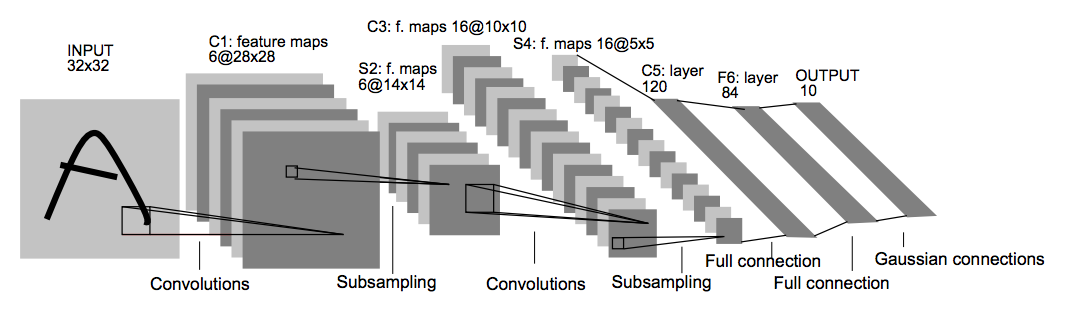

Bu ConvNet şu adımları izler:

Giriş => Evrişim => ReLU => Havuzlama => Evrişim => ReLU => Havuzlama => Tam Bağlantılı => ReLU => Tam Bağlantılı


Katman 1 (Evrişimli): Çıktı şekli 28x28x6 olmalıdır.

Havuzlama. Çıktı şekli 14x14x6 olmalıdır.

Katman 2 (Evrişimli): Çıktı şekli 10x10x16 olmalıdır.

Havuzlama. Çıktı şekli 5x5x16 olmalıdır.

Düzleştirme: Son havuzlama katmanının çıktı şeklini 3B yerine 1B olacak şekilde düzleştirin.

Katman 3 (Tam Bağlı): Bunun 120 çıkışı olmalıdır.

Katman 4 (Tam Bağlı): Bunun 84 çıkışı olmalıdır.

Katman 5 (Tam Bağlı): Bunun 43 çıkışı olmalıdır.

In [50]:
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):#self fonksiyonunu kullanıyoruz her nörona bir özelliği tutturuyoruz
        # hiperparametreler
        self.mu = mu
        self.sigma = sigma

        # Katman 1 (Evrişimli): Girdi = 32x32x1. Çıktı = 28x28x6.
        self.filter1_width = 5 #genişlik 5 piksel
        self.filter1_height = 5 #yükseklik 5 piksel görüntünün seçilmesi
        self.input1_channels = 1 # giriş katman sayısı
        self.conv1_output = 6 #1.çıkış katman sayısı
        # Ağırlık ve önyargı
        self.conv1_weight = tf.Variable(tf.truncated_normal(#ağırlık değerlerinin istediğimiz şekilde doldurulması.
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Evrişimi Uygula tf.nn parametreleri yüklemek için kullanıyoruz.
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias#strides kaydırma adım sayısı ,uygulanan işlemlerden sonra çıktı boyutunun küçük olmasını engeller
        #kernel size olarak 5*5 görselleme seçtik 
        # Aktivasyon:
        self.conv1 = tf.nn.relu(self.conv1)  # negatif değerleri relu aktivason fonksiyonu ile absorbe ediyoruz.
        #28*28*6 olmasının nedeni ((width=5*height=5*channel=1*output=6)+bias=6)=156 bu sonucta 28*28*156 'dan 122304 bağlantı oluşturma demektir.'
        
    
        #Havuzlama: Giriş = 28x28x6. Çıktı = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') #kernel ve strides değerlerini aynı vermesi görüntünün çakışmasını engeller hazvuzlamada
        #ksize 2*2 ayarlıyoruz burda 2*2 lik görselde havuzlama yapacak
        
        # Katman 2 (Evrişimli): Çıktı = 10x10x16.
        self.filter2_width = 5 #genişlik 5 piksel
        self.filter2_height = 5 #yükseklik 5 piksel görüntünün seçilmesi
        self.input2_channels = 6 #giriş katman sayısı
        self.conv2_output = 16 #2.çıkış katman sayısı
        # Ağırlık ve önyargı
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Evrişimi Uygula
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Aktivasyon:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Havuzlama: Giriş = 10x10x16. Çıktı = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') #max 
        
        # Düzleştirme: Girdi = 5x5x16. Çıktı = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Katman 3 (Tam Bağlı): Giriş = 400. Çıkış = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Aktivasyon:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Katman 4 (Tam Bağlı): Giriş = 120. Çıkış = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Aktivasyon:
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Katman 5 (Tam Bağlı): Giriş = 84. Çıkış = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Eğitim operasyonu
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Doğruluk işlemi
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Tüm değişkenleri kaydetme
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

# 2. VGGNet
VGGNet ilk olarak 2014 yılında Oxford Üniversitesi'nden K. Simonyan ve A. Zisserman tarafından Büyük Ölçekli Görüntü Tanıma için Çok Derin Evrişimli Ağlar adlı bir makaleyle tanıtıldı. Evrişimli ağ derinliğini, büyük ölçekli görüntü tanıma ayarlarındaki doğruluğu üzerinde araştırıyorlardı. Başlıca katkıları, derinliği 16-19 ağırlık katmanına iterek önceki tekniğe göre önemli bir gelişmenin elde edilebileceğini gösteren çok küçük (3x3) evrişim filtrelerine sahip bir mimari kullanarak artan derinliğe sahip ağların kapsamlı bir değerlendirmesidir.9 ağırlıklı katman kullandık bunlar 6Evrişimli Katmanlar, 3 Tamamen Bağlantılı Katman

VGGNet mimarisi: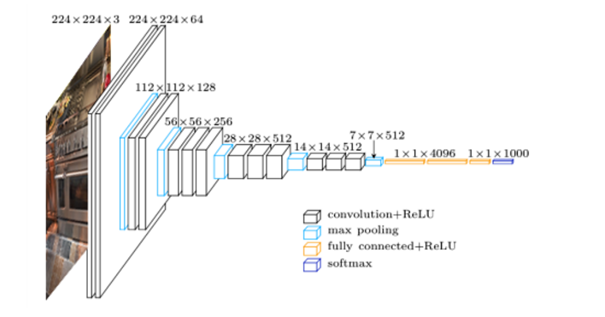
 
 
 Orijinal VGGNet mimarisi 16-19 katmana sahiptir, ancak hesaplama kaynaklarından tasarruf etmek için bazılarını hariç tuttuk ve yalnızca 12 katmanın değiştirilmiş bir sürümünü uyguladık.

Bu ConvNet şu adımları izler:

Giriş => Evrişim => ReLU => Evrişim => ReLU => Havuzlama => Evrişim => ReLU => Evrişim => ReLU => Havuzlama => Evrişim => ReLU => Evrişim => ReLU => Havuzlama => Tam Bağlantılı = > ReLU => Tam Bağlı => ReLU => Tam Bağlı


Katman 1 (Evrişimli): Çıktı şekli 32x32x32 olmalıdır.

Katman 2 (Evrişimli): Çıktı şekli 32x32x32 olmalıdır.

Katman 3 (Havuzlama) Çıktı şekli 16x16x32 olmalıdır.

Katman 4 (Evrişimli): Çıktı şekli 16x16x64 olmalıdır.

Katman 5 (Evrişimli): Çıktı şekli 16x16x64 olmalıdır.

Layer 6 (Pooling) Çıktı şekli 8x8x64 olmalıdır.

Katman 7 (Evrişimli): Çıktı şekli 8x8x128 olmalıdır.

Katman 8 (Evrişimli): Çıktı şekli 8x8x128 olmalıdır.

Katman 9 (Havuzlama) Çıktı şekli 4x4x128 olmalıdır.

Düzleştirme: Son havuzlama katmanının çıktı şeklini 3B yerine 1B olacak şekilde düzleştirin.

Katman 10 (Tam Bağlı): Bunun 128 çıkışı olmalıdır.

Katman 11 (Tam Bağlı): Bunun 128 çıkışı olmalıdır.

Katman 12 (Tam Bağlı): Bunun 43 çıkışı olmalıdır.

In [51]:
class VGGnet:  
    
    #Model, daha derin bir ağ yapısı oluşturmak için nispeten kolay olan birkaç evrişimli katmanın ve havuzlama katmanının üst üste dizilmesiyle oluşturulur.

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # hiperparametreler
        self.mu = mu # 0 eşitlemede kullanıyoruz
        self.sigma = sigma

        #Katman 1 (Evrişimli): Girdi = 32x32x1. Çıktı = 32x32x32.
        #height=3,width=3,girilen ktanman saıyısı=1,çıkış katman sayısı32
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))#weight değeri
        self.conv1_b = tf.Variable(tf.zeros(32))#bias değerini tanımladık
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b #ksize 3*3 başta ayarladık ona göre 1*1 yeniden boyutlandırıldı.
        #strides kaydırma adım sayısı
        # ReLu Aktivasyonu.
        self.conv1 = tf.nn.relu(self.conv1)# negatif değerleri relu aktivason fonksiyonu ile absorbe ediyoruz.

        # Katman 2 (Evrişimli): Girdi = 32x32x32. Çıktı = 32x32x32.
        #height=3,width=3,girilen ktanman saıyısı=32,çıkış katman sayısı32
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))#bias değerini tanımladık
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        # ReLu Aktivasyonu.
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Katman 3 (Havuzlama): Girdi = 32x32x32. Çıktı = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')#ksize blurlama  #kernel ve strides değerlerini aynı vermesi görüntünün çakışmasını engeller hazvuzlamada
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv) # dropout Buradaki ana fikir, onları rastgele bırakmaktır. Bu, her eğitim adımında girdi nöronlarının bir kısmını belirli bir katmana bırakarak yapılır.
        
        #height=3,width=3,girilen ktanman saıyısı=32,çıkış katman sayısı64
        # Katman 4 (Evrişimli): Girdi = 16x16x32. Çıktı = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))#bias değerini tanımladık
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Aktivasyonu..
        self.conv3 = tf.nn.relu(self.conv3)

        # Katman 5 (Evrişimli): Girdi = 16x16x64. Çıktı = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        # ReLu Aktivasyonu.
        self.conv4 = tf.nn.relu(self.conv4)

        # Katman 6 (Havuz): Girdi = 16x16x64. Çıktı = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout Buradaki ana fikir, onları rastgele bırakmaktır. Bu, her eğitim adımında girdi nöronlarının bir kısmını belirli bir katmana bırakarak yapılır.

        # Katman 7 (Evrişimli): Girdi = 8x8x64. Çıktı = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Aktivasyonu.
        self.conv5 = tf.nn.relu(self.conv5)

        # Katman 8 (Evrişimli): Girdi = 8x8x128. Çıktı = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Aktivasyonu.
        self.conv6 = tf.nn.relu(self.conv6)

        # Katman 9 (Havuzlama): Girdi = 8x8x128. Çıktı = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Düzleştirmek. Giriş = 4x4x128. Çıktı = 2048.
        self.fc0   = flatten(self.conv6)

        # Katman 10 (Tam Bağlı): Giriş = 2048. Çıkış = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b #A * B olmak üzere iki matrisin iç çarpımını hesaplamak için kullanılır. 
        #matrise bias değerini ekleyip aktivasyon fonksiyonuna sokuyoruz.

        # ReLu Aktivasyonu.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Katman 11 (Tam Bağlı): Giriş = 128. Çıkış = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

       # ReLu Aktivasyonu.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Katman 12 (Tam Bağlı): Giriş = 128. Çıkış = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Eğitim operasyonu
        self.one_hot_y = tf.one_hot(y, n_out)#Temel olarak, belirli bir kategorinin belirli bir öğesinin mevcut olup olmadığını belirtiyoruz. 0 ya da 1 değeri vererek
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y) #Logitler ve etiketler arasındaki softmax çapraz entropiyi hesaplar.
        self.loss_operation = tf.reduce_mean(self.cross_entropy) #Bir tensörün boyutları boyunca öğelerin ortalamasını hesaplar.
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)#Adam algoritmasını uygulayan optimize edici.
        self.training_operation = self.optimizer.minimize(self.loss_operation)#eğittiğimiz kendi optimize edicimizi kullandık.

        # Doğruluk işlemi
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))#değerlerin x==y cndisinden doğruluğunu döndürür
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))#ortalamayı yeni bir tensor içerisine atadık.

        # Tüm değişkenleri kaydetme
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):#Batch size parti boyutu yani aralık ilk 64 sonra 64 er şeklinde.
        num_examples = len(X_data)#x_datanın uzunluğu
        y_pred = np.zeros(num_examples, dtype=np.int32)#0larla dolu bir boş dizi döndürür train data  kadar
        sess = tf.get_default_session()#Geçerli iş parçacığı için varsayılan sesionı döndürür.
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

# Step 4: Model Training and Evaluation
Bu adımda, modelimizi normalized_images kullanarak eğiteceğiz, ardından modelin hata olasılığını ölçmek için logitler ve etiketler arasındaki softmax çapraz entropisini hesaplayacağız.

x, bir dizi girdi görüntüsünü tutar. y, bir dizi çıktı etiketi için yer tutar.

In [52]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

nöral ağı eğitirken bırakma oranını kontrol etmek için keep_prob ve keep_prob_conv değişkenleri kullanılacaktır. Aşırı uyum, derin sinir ağlarında ciddi bir sorundur. Bırakma, bu sorunu ele almak için bir tekniktir. Temel fikir, eğitim sırasında birimleri (bağlantılarıyla birlikte) sinir ağından rastgele bırakmaktır. Bu, birimlerin çok fazla birlikte uyum sağlamasını engeller. Eğitim sırasında, üstel sayıda farklı "inceltilmiş" ağdan örnekleri bırakın. Test zamanında, daha küçük ağırlıklara sahip inceltilmemiş tek bir ağ kullanarak tüm bu inceltilmiş ağların tahminlerinin ortalamasını almanın etkisini yaklaşık olarak tahmin etmek kolaydır. Bu, aşırı uydurmayı önemli ölçüde azaltır ve diğer düzenlileştirme yöntemlerine göre büyük iyileştirmeler sağlar. Bu teknik, N. Srivastava, G. Hinton, A. Krizhevsky I. Sutskever ve R. Salakhutdinov tarafından Dropout: A Simple Way to Prevention Neural Networks from Overfitting adlı makalelerinde tanıtıldı.

In [53]:
keep_prob = tf.placeholder(tf.float32)       # Tamamen bağlı katmanlar için
keep_prob_conv = tf.placeholder(tf.float32)  # Evrişimli katmanlar için

In [56]:
# Doğrulama seti ön işlemesi
X_valid_preprocessed = preprocess(X_valid)#grileştirme ve başta yazdıpımız diğer fonksiyonların aynı anda uygulanması.

In [57]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

# LeNet Model
Şimdi, modeli eğitmek için eğitim verilerini eğitim boru hattı üzerinden çalıştıracağız.

!epochlar kaç kere uygulanacağı

Her epoch'dan önce, eğitim setini karıştıracağız.

Her epoch'dan sonra doğrulama setinin kaybını ve doğruluğunu ölçeriz.

Ve eğitimden sonra modeli kaydedeceğiz.

Eğitim ve doğrulama setlerinde düşük bir doğruluk, yetersiz uyum anlamına gelir. Eğitim setinde yüksek doğruluk, ancak doğrulama setinde düşük doğruluk, fazla uydurma anlamına gelir.

In [58]:
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):  #epoch sayısını kaç verirsek o kadar eğitilicek model
        normalized_images, y_train = shuffle(normalized_images, y_train)#dataseti karıştıracak normalized images preproccess fonksiyonundan dönen
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))#lenet modeli dosyayla aynı klasöre kaydetiyoruz eğittiğimiz.
    print("Model saved")

Training ...

EPOCH 1 : Validation Accuracy = 79.501%
EPOCH 2 : Validation Accuracy = 87.324%
EPOCH 3 : Validation Accuracy = 89.569%
EPOCH 4 : Validation Accuracy = 89.365%
EPOCH 5 : Validation Accuracy = 90.023%
EPOCH 6 : Validation Accuracy = 91.247%
EPOCH 7 : Validation Accuracy = 91.043%
EPOCH 8 : Validation Accuracy = 91.429%
EPOCH 9 : Validation Accuracy = 89.615%
EPOCH 10 : Validation Accuracy = 91.020%
EPOCH 11 : Validation Accuracy = 93.311%
EPOCH 12 : Validation Accuracy = 90.794%
EPOCH 13 : Validation Accuracy = 91.293%
EPOCH 14 : Validation Accuracy = 90.522%
EPOCH 15 : Validation Accuracy = 92.404%
EPOCH 16 : Validation Accuracy = 92.449%
EPOCH 17 : Validation Accuracy = 91.270%
EPOCH 18 : Validation Accuracy = 92.789%
EPOCH 19 : Validation Accuracy = 93.107%
EPOCH 20 : Validation Accuracy = 93.243%
EPOCH 21 : Validation Accuracy = 93.175%
EPOCH 22 : Validation Accuracy = 92.562%
EPOCH 23 : Validation Accuracy = 92.902%
EPOCH 24 : Validation Accuracy = 92.857%
EPOCH 25 : 

Gördüğümüz gibi, 0,001'lik bir öğrenme oranı kullanarak, 30 dönem boyunca doğrulama setinde maksimum %95,3'lük bir doğruluğa ulaşabildik.

Şimdi VGGNet modelini eğiteceğiz ve doğruluğunu değerlendireceğiz.

In [59]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Doğrulama seti ön işlemesi
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)#indeksleri olan 43 claasın alması için

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())#tutmasını söylediğmiz değerleri tutuyor.
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)#preproccessden döndüğümüz görseller normalized_images.
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 17.098%
EPOCH 2 : Validation Accuracy = 47.800%
EPOCH 3 : Validation Accuracy = 78.435%
EPOCH 4 : Validation Accuracy = 88.481%
EPOCH 5 : Validation Accuracy = 92.018%
EPOCH 6 : Validation Accuracy = 95.828%
EPOCH 7 : Validation Accuracy = 96.304%
EPOCH 8 : Validation Accuracy = 97.778%
EPOCH 9 : Validation Accuracy = 98.050%
EPOCH 10 : Validation Accuracy = 98.821%
EPOCH 11 : Validation Accuracy = 98.367%
EPOCH 12 : Validation Accuracy = 97.868%
EPOCH 13 : Validation Accuracy = 98.571%
EPOCH 14 : Validation Accuracy = 98.776%
EPOCH 15 : Validation Accuracy = 98.141%
EPOCH 16 : Validation Accuracy = 98.345%
EPOCH 17 : Validation Accuracy = 99.093%
EPOCH 18 : Validation Accuracy = 99.093%
EPOCH 19 : Validation Accuracy = 98.798%
EPOCH 20 : Validation Accuracy = 98.730%
EPOCH 21 : Validation Accuracy = 99.048%
EPOCH 22 : Validation Accuracy = 98.662%
EPOCH 23 : Validation Accuracy = 98.844%
EPOCH 24 : Validation Accuracy = 98.980%
EPOCH 25 : V

# Step 5: Test Setini Kullanarak Modeli Test Etme
Şimdi, modelin doğruluğunu bilinmeyen örnekler üzerinden ölçmek için test setini kullanacağız.

In [60]:
# Test seti ön işlemesi
X_test_preprocessed = preprocess(X_test)

In [61]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models\VGGNet
Test Accuracy = 97.4%


Şimdi modelin gerçekte nerede başarısız olduğunu görmek için karışıklık matrisini çizeceğiz.

Aşağıdaki karışıklık matrisinde bazı kümeler gözlemliyoruz. Çeşitli hız sınırlarının bazen kendi aralarında yanlış sınıflandırıldığı ortaya çıktı. Benzer şekilde, üçgen şekilli trafik işaretleri de kendi aralarında yanlış sınıflandırılmaktadır. Önce daha geniş grupları (hız işaretleri gibi) tanımlamak için hiyerarşik CNN'leri kullanarak modeli daha da geliştirebilir ve ardından daha ince özellikleri (gerçek hız sınırı gibi) sınıflandırmak için CNN'lere sahip olabiliriz.

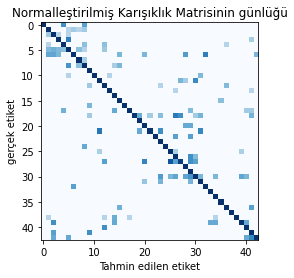

In [62]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalleştirilmiş Karışıklık Matrisinin günlüğü')
plt.ylabel('gerçek etiket')
plt.xlabel('Tahmin edilen etiket')
plt.show()

# 6. Adım: Modeli Yeni Görseller Üzerinde Test Etme
Bu adımda, modeli, trafik işaretlerinin 5 rastgele görüntüsünün trafik işaretleri türünü tahmin etmek için bu webden aldığımız test görüntülerini inceleyip üzerindeki performansını tahmin etmek için kullanacağız.

In [65]:
# Yeni test görüntüleri yükleme ve yeniden boyutlandırma
new_test_images = []
path = './trafficSignsDataset/new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17]
print("Yeni test örneklerinin sayısı:", len(new_test_images))

Yeni test örneklerinin sayısı: 5


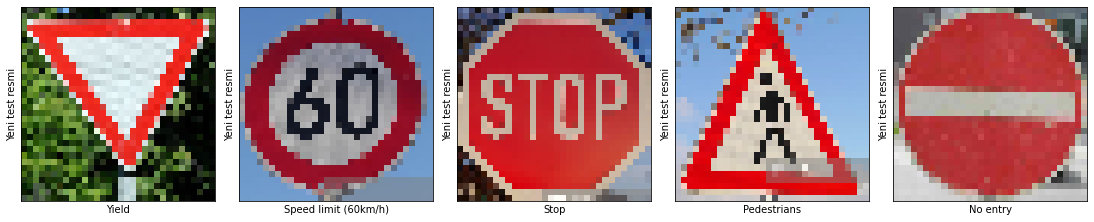

In [66]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(1,5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("Yeni test resmi")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=1)
plt.show()

In [67]:
#Yeni test verileri ön işleme
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models\VGGNet
Yeni Görüntülerin Test Doğruluğu = 100.0%


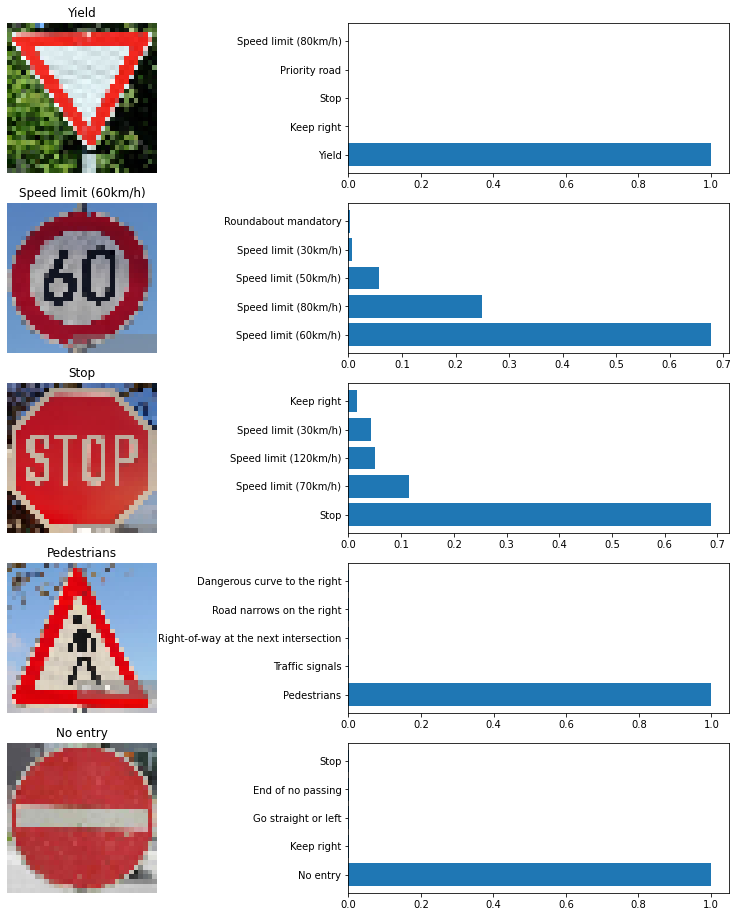

In [68]:
def y_predict_model(Input_data, top_k=5):
    """
   Girdi verileri üzerinden modelin tahminlerini üretir ve en yüksek softmax olasılıklarını verir.
        parametreler:
            X_data: Veri girişi.
            top_k (Varsayılan = 5): Oluşturulacak üst softmax olasılıklarının sayısı.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("Yeni Görüntülerin Test Doğruluğu = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :]) #5 tane doğruya yakın çıkan classlardan sıralıycak bar olarak 
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)# üstteki çağırdıklarımızla birleştirdik
plt.show()